# Turn around Tuesday

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import activity as act
import utils as self_utils
from quantified_strategies import strategy_utils as utils

In [2]:
START = dt.date(2020, 1, 1)
START = dt.date(2010, 1, 1)
END = dt.date.today()

In [3]:

def run(ticker: str, start: dt.date = START, end: dt.date = END) -> pd.DataFrame:

    def calculate_strategy_returns(df: pd.DataFrame) -> pd.DataFrame:
        df["strat_ret"] = df["ret_shifted"] * df["pos"]
        df["cum_strat_ret"] = utils.get_cumulative_return(returns=df["strat_ret"], total=False)
        df["cum_hodl_ret"] = utils.get_cumulative_return(returns=df["ret_shifted"], total=False)
        return df

    def calculate_trade_returns(df: pd.DataFrame) -> pd.DataFrame:
        
        df["trade_number"] = df["enter_flag"].cumsum()
        
        trade_ret = (
            df
            .dropna(subset="strat_ret")
            .groupby("trade_number")["strat_ret"]
            .apply(lambda ret: utils.get_cumulative_return(returns=ret, total=True))
        )
        trade_ret.index = trade_ret.index.map(df.loc[df["enter_flag"]].reset_index().set_index("trade_number")["Date"].to_dict())
        trade_ret = trade_ret.loc[~trade_ret.index.isna()]

        df = pd.concat([df, trade_ret.to_frame(name="trade_strat_ret")], axis=1)

        return df
        
    # Get Data
    data = self_utils.fetch(ticker=ticker)
    
    data = data.rename(columns={"Adj Close": "asset", "High": "asset_high"})

    # Filter data
    data = data.loc[(data.index.date >= START) & (data.index.date <= END)].copy()

    # Convert data
    data["ret"] = data["asset"].pct_change(fill_method=None)
    data["ret_shifted"] = data["ret"].shift(-1)

    # Get Activity
    data["active"] = act.get_activity(data=data)
    data["pos"] = data["active"].astype(int)
    
    # Calculate Returns
    data = calculate_strategy_returns(df=data)

    # Calculate Trade Returns
    data = calculate_trade_returns(df=data)
    
    return data


## Rules

1. Today must be a Monday
2. The Close must be lower than Friday's close
3. If 1 and 2 are true, then buy at the close
4. Sell when today's close is higher than yesterday's high or after 5 trading days.

In [4]:
TICKER = "SPY.US"
results = self_utils.run(ticker=TICKER, full=True, start=START, end=END)
results

{}
remove api from here


,asset,asset_high,ret,ret_shifted,is_monday,price_less_than_yday_price,enter_flag,price_today_higher_than_yday_high,five_trading_days_later,exit_flag,pos,active,strat_ret,cum_strat_ret,cum_hodl_ret,trade_number
Date,,,,,,,,,,,,,,,,
2010-01-04,87.1290,113.390,NaN,0.002647,True,False,False,False,NaN,False,0,False,0.000000,0.000000,0.002647,0
2010-01-05,87.3596,113.680,0.002647,0.000704,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.003353,0
2010-01-06,87.4211,113.990,0.000704,0.004222,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.007589,0
2010-01-07,87.7902,114.330,0.004222,0.003327,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.010941,0
2010-01-08,88.0823,114.620,0.003327,0.001396,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.012353,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-27,506.9300,507.160,0.001858,-0.001322,False,False,False,False,False,False,1,True,-0.001322,2.108658,4.810465,176
2024-02-28,506.2600,506.855,-0.001322,0.003595,False,True,False,False,False,False,1,True,0.003595,2.119834,4.831354,176
2024-02-29,508.0800,509.740,0.003595,0.009388,False,False,False,True,False,True,0,False,0.000000,2.119834,4.886100,176


In [5]:
TICKERS = ["SPY.US", "QQQ.US"]
# TICKERS = ["XLK.US", "XLB.US", "XLY.US"]
# TICKERS = ['VUSA.LSE', "CNX1.LSE"]

In [6]:
data_dict = {ticker: run(ticker=ticker) for ticker in TICKERS}

{}
remove api from here
{}
remove api from here


In [8]:
data_dict[TICKERS[0]]

,asset,asset_high,ret,ret_shifted,is_monday,price_less_than_yday_price,enter_flag,price_today_higher_than_yday_high,five_trading_days_later,exit_flag,pos,active,strat_ret,cum_strat_ret,cum_hodl_ret,trade_number,trade_strat_ret
2010-01-04,87.1290,113.390,NaN,0.002647,True,False,False,False,NaN,False,0,False,0.000000,0.000000,0.002647,0,NaN
2010-01-05,87.3596,113.680,0.002647,0.000704,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.003353,0,NaN
2010-01-06,87.4211,113.990,0.000704,0.004222,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.007589,0,NaN
2010-01-07,87.7902,114.330,0.004222,0.003327,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.010941,0,NaN
2010-01-08,88.0823,114.620,0.003327,0.001396,False,False,False,False,NaN,False,0,False,0.000000,0.000000,0.012353,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-27,506.9300,507.160,0.001858,-0.001322,False,False,False,False,False,False,1,True,-0.001322,2.108658,4.810465,292,NaN
2024-02-28,506.2600,506.855,-0.001322,0.003595,False,True,False,False,False,False,1,True,0.003595,2.119834,4.831354,292,NaN
2024-02-29,508.0800,509.740,0.003595,0.009388,False,False,False,True,False,True,0,False,0.000000,2.119834,4.886100,292,NaN
2024-03-01,512.8500,513.290,0.009388,-0.001072,False,False,False,True,False,True,0,False,-0.000000,2.119834,4.879787,292,NaN


## Plot Strategy Results

In [9]:
TICKER = TICKERS[0]
data = data_dict[TICKER]

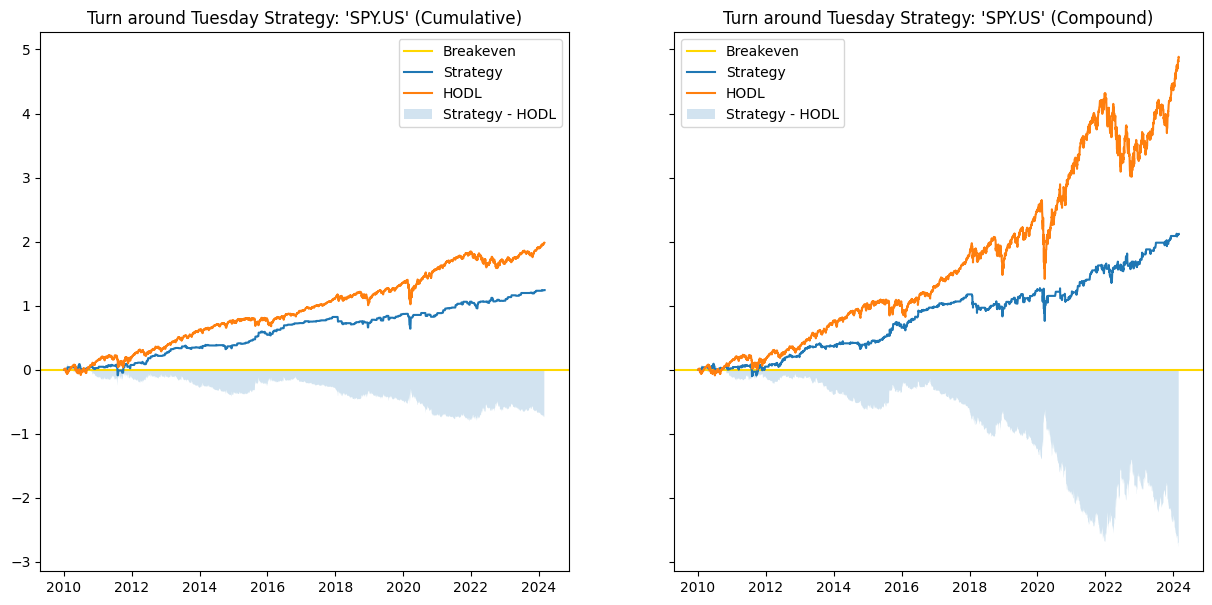

In [10]:
fig, ax = plt.subplots(ncols=2, sharey=1, figsize=(15, 7))

ax[0].axhline(y=0, label="Breakeven", color="gold")
ax[1].axhline(y=0, label="Breakeven", color="gold")

ax[0].plot(data["trade_strat_ret"].fillna(0.0).cumsum(), label="Strategy")
ax[0].plot(data["ret_shifted"].cumsum(), label="HODL")
ax[0].fill_between(
    data.index.tolist(), 
    data["trade_strat_ret"].fillna(0.0).cumsum()-data["ret_shifted"].cumsum(),
    alpha=0.20,
    label="Strategy - HODL",
)
ax[0].set_title(f"Turn around Tuesday Strategy: {TICKER!r} (Cumulative)")
ax[0].legend(loc="best")

ax[1].plot(data["cum_strat_ret"], label="Strategy")
ax[1].plot(data["cum_hodl_ret"], label="HODL")
ax[1].fill_between(
    data.index.tolist(), 
    data["cum_strat_ret"] - data["cum_hodl_ret"],
    alpha=0.20,
    label="Strategy - HODL",
)
ax[1].set_title(f"Turn around Tuesday Strategy: {TICKER!r} (Compound)")
ax[1].legend(loc="best")


plt.show()

## Describe Strategy Results

In [11]:
pd.concat([
    utils.describe(returns=data["strat_ret"], pos=data["pos"], daily=True, asset=TICKER).to_frame(name="daily_strategy"),
    utils.describe(returns=data["trade_strat_ret"].dropna(), daily=False, asset=TICKER).to_frame(name="trade_strategy"),
    utils.describe(returns=data["ret_shifted"], daily=True, asset=TICKER).to_frame(name="hodl"),
], axis=1)

,daily_strategy,trade_strategy,hodl
Asset,SPY.US,SPY.US,SPY.US
Start,2010-01-04,2010-02-08,2010-01-04
End,2024-03-04,2024-02-26,2024-03-04
Mean Return,0.08913%,0.42549%,0.05566%
Total Return,211.98%,211.98%,487.98%
Median Return,0.10403%,0.51787%,0.06585%
1st Quartile,-0.39241%,-0.72629%,-0.37397%
3rd Quartile,0.66837%,1.58069%,0.57944%
Std Dev Return,1.23448%,2.65328%,1.08782%
CAGR,8.142 bps,39.041 bps,4.970 bps


# Portfolio

In [12]:
hodl_rets = pd.concat([data["ret_shifted"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
rets = pd.concat([data["strat_ret"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
trade_rets = pd.concat([data["trade_strat_ret"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
deltas = pd.concat([data["pos"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1).sort_index()
deltas = deltas.div(deltas.sum(axis=1), axis=0).fillna(0.0)

In [13]:
def calculate_trade_returns(df: pd.DataFrame, deltas: pd.Series) -> pd.DataFrame:

    df.index.name = "Date"
    df = df.loc[:, df.columns != "trade_strat_ret"]
    df["enter_flag"] = df["enter_flag"] + deltas.diff().clip(lower=0.0)
    df["strat_ret"] = df["strat_ret"] * deltas
    
    df["trade_number"] = df["enter_flag"].cumsum()
    
    trade_ret = (
        df
        .dropna(subset="strat_ret")
        .groupby("trade_number")["strat_ret"]
        .apply(lambda ret: utils.get_cumulative_return(returns=ret, total=True))
    )
    trade_ret.index = trade_ret.index.map(df.loc[df["enter_flag"] > 0].reset_index().set_index("trade_number")["Date"].to_dict())
    trade_ret = trade_ret.loc[~trade_ret.index.isna()]

    df = pd.concat([df, trade_ret.to_frame(name="trade_strat_ret")], axis=1)

    return df

port_trade_rets = pd.concat([calculate_trade_returns(df=data.copy(), deltas=deltas[ticker])["trade_strat_ret"].to_frame(name=ticker) for ticker, data in data_dict.items()], axis=1)
port_trade_rets = port_trade_rets.dropna(how="all").sum(axis=1)
port_trade_rets.head(5)

2010-01-11    0.004961
2010-02-08    0.037297
2010-02-22    0.014976
2010-03-15    0.015480
2010-04-19    0.018385
dtype: float64

In [14]:
port_rets = (rets * deltas).sum(axis=1)
port_rets.head(5)

2010-01-04    0.0
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
dtype: float64

In [15]:
hodl_rets = hodl_rets.mean(axis=1)
hodl_rets.head(5)

2010-01-04    0.001323
2010-01-05   -0.002664
2010-01-06    0.002436
2010-01-07    0.005778
2010-01-08   -0.001342
dtype: float64

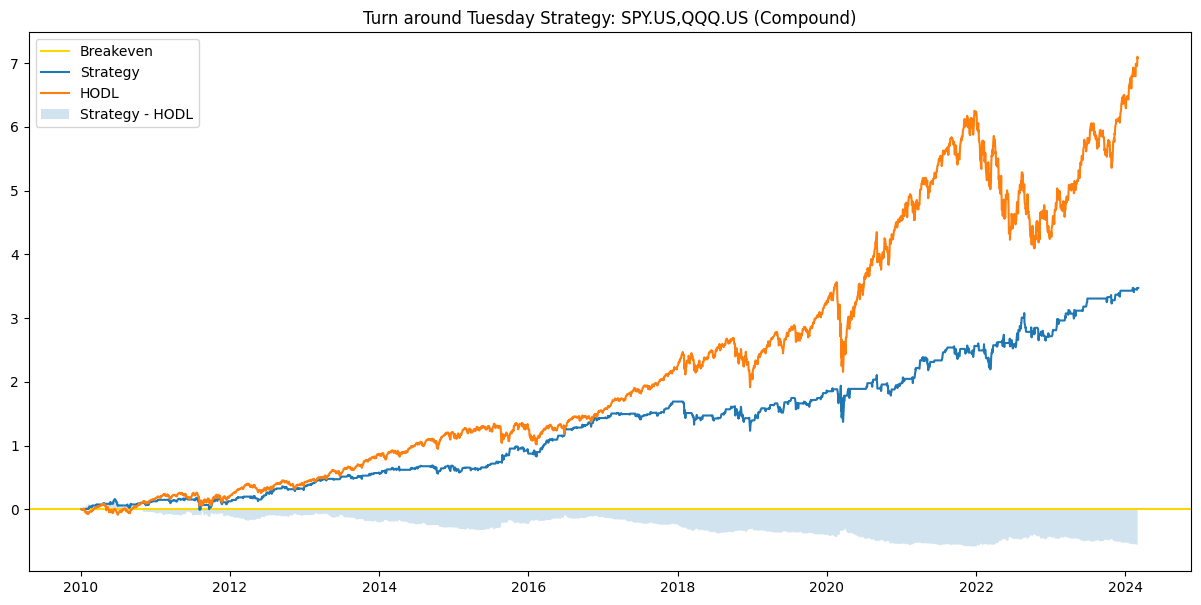

In [16]:
fig, ax = plt.subplots(ncols=1, sharey=1, figsize=(15, 7))

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(utils.get_cumulative_return(returns=port_rets, total=False), label="Strategy")
ax.plot(utils.get_cumulative_return(returns=hodl_rets, total=False), label="HODL")
ax.fill_between(
    port_rets.index.tolist(), 
    utils.get_cumulative_return(returns=port_rets-hodl_rets, total=False),
    alpha=0.20,
    label="Strategy - HODL",
)
ax.set_title(f"Turn around Tuesday Strategy: {','.join(TICKERS)} (Compound)")
ax.legend(loc="best")

plt.show()

In [17]:
pd.concat([
    utils.describe(returns=port_rets, pos=deltas.sum(axis=1), daily=True, asset=",".join(TICKERS)).to_frame(name="daily_strategy"),
    utils.describe(returns=port_trade_rets, daily=False, asset=",".join(TICKERS)).to_frame(name="trade_strategy"),
    utils.describe(returns=hodl_rets, daily=True, asset=",".join(TICKERS)).to_frame(name="hodl"),
], axis=1)

,daily_strategy,trade_strategy,hodl
Asset,"SPY.US,QQQ.US","SPY.US,QQQ.US","SPY.US,QQQ.US"
Start,2010-01-04,2010-01-11,2010-01-04
End,2024-03-04,2024-02-26,2024-03-04
Mean Return,0.10052%,0.44718%,0.06551%
Total Return,347.28%,349.81%,708.18%
Median Return,0.10165%,0.62700%,0.09223%
1st Quartile,-0.43076%,-0.69235%,-0.41327%
3rd Quartile,0.71623%,1.72735%,0.64068%
Std Dev Return,1.26789%,2.53668%,1.16988%
CAGR,9.246 bps,41.509 bps,5.863 bps
